# Описание проекта

Мы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.  

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Описание данных  

***Name*** — название игры  

***Platform*** — платформа  

***Year_of_Release*** — год выпуска  

***Genre*** — жанр игры  

***NA_sales*** — продажи в Северной Америке (миллионы проданных копий)  

***EU_sales*** — продажи в Европе (миллионы проданных копий)  

***JP_sales*** — продажи в Японии (миллионы проданных копий)  

***Other_sales*** — продажи в других странах (миллионы проданных копий)   

***Critic_Score*** — оценка критиков (максимум 100)  

***User_Score*** — оценка пользователей (максимум 10)  

***Rating*** — рейтинг от организации ***ESRB*** (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  

Данные за 2016 год могут быть неполными.

In [1]:
!pip install missingno

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import missingno as msno

#### Шаг 1. Откройте файл с данными и изучите общую информацию.  

Путь к файлу: /datasets/games.csv.

In [2]:
# df = pd.read_csv('/datasets/games.csv')
df = pd.read_csv("\\Users\\1537d\\Downloads\\games.csv")

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Шаг 2. Подготовка даннх

##### Заменим названия столбцов (приведем к нижнему регистру);  

Воспользуемся функциею **lambda** и **lower()**. Первая позволит применить метод **lower()** который приведёт названия всех столбцов к нижнему регистру.

In [5]:
df = df.rename(columns=lambda x: x.lower())
df.columns # взглнем на результат.

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

##### Преобразуем данные в нужные типы. Опишим, в каких столбцах заменили тип данных и почему;

Из части 1 в которой мы увидели, что в столбце **critic_score** — оценка пользователей, типа данных **object**. Изменим на **float64**. Используем метод **to_numeric** с параметром **errors='coerce'** который при встрече с не цифровыми значениями заменит их на NaN.

In [6]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Блогадаря этому мы сможем проводить математические операции с данными этого столбца.

##### Обработайте пропуски при необходимости:

В нашем **df** в двух столбцах "название" и "жанр" имеется 2 пропуска. Взглянем на эти пропуски.

In [7]:
df.query('genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В данных строках отсутствует данные по платформе, название и жанр, есть оценки и платформа, но по этим данным нельзя, что-то определить. Просто удалим эти строки.

In [8]:
df = df.dropna(subset=['name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


Взглянем на пропуски в столбце **year_of_release** — год выхода.

In [9]:
df.query('year_of_release.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Заменим неизвестные значения рейтинг на "unknown".

Посмотрим оценки критика и оценке пользователя.

In [10]:
df['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
       82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94.,
       95., 96., 97., 98., nan])

<!-- #df['critic_score'] = df['critic_score'].fillna(-1) -->

In [11]:
df['user_score'].sort_values().unique()

array([0. , 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5,
       1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
       2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1,
       4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4,
       5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7,
       6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ,
       8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3,
       9.4, 9.5, 9.6, 9.7, nan])

<!--  df['user_score'] = df['user_score'].fillna(-1) -->

In [12]:
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

In [13]:
df['rating'] = df['rating'].fillna('unknown')
df.reset_index(drop=True);

Визуализируем наши пропуски

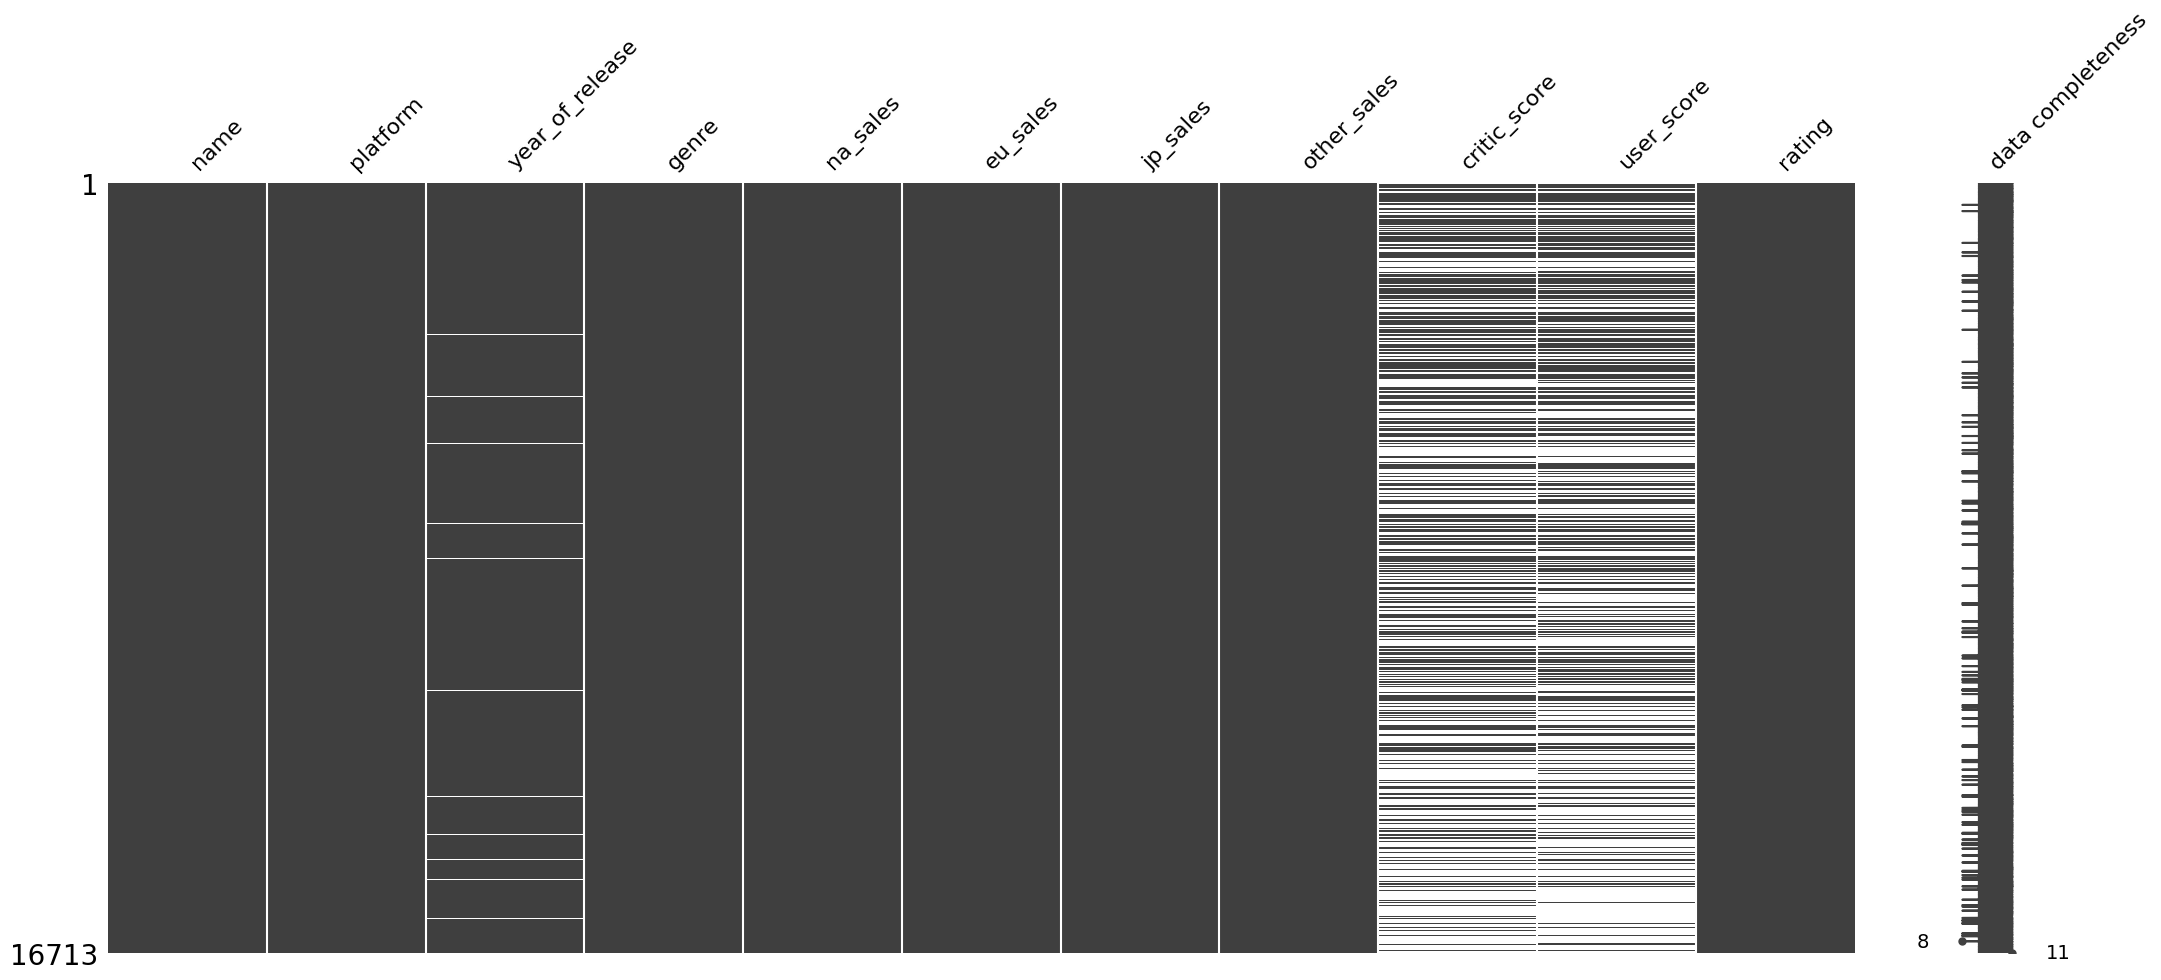

In [14]:
msno.matrix(df, labels=True);

Теперь наши данные практически полностью заполнены Оставшиеся пропуски оставим, их всегда можно будет отфильтровать.

In [15]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
#             .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (17,5), legend = False, fontsize = 15, grid=True)   
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')
        
    plt.title('Пропущенные значения, %' + "\n", fontsize=22)
    plt.xlabel('Процент пропусков', fontsize=15)
    plt.ylabel('Столбцы с пропусками', fontsize=15)
    plt.xlim(0, 100) 

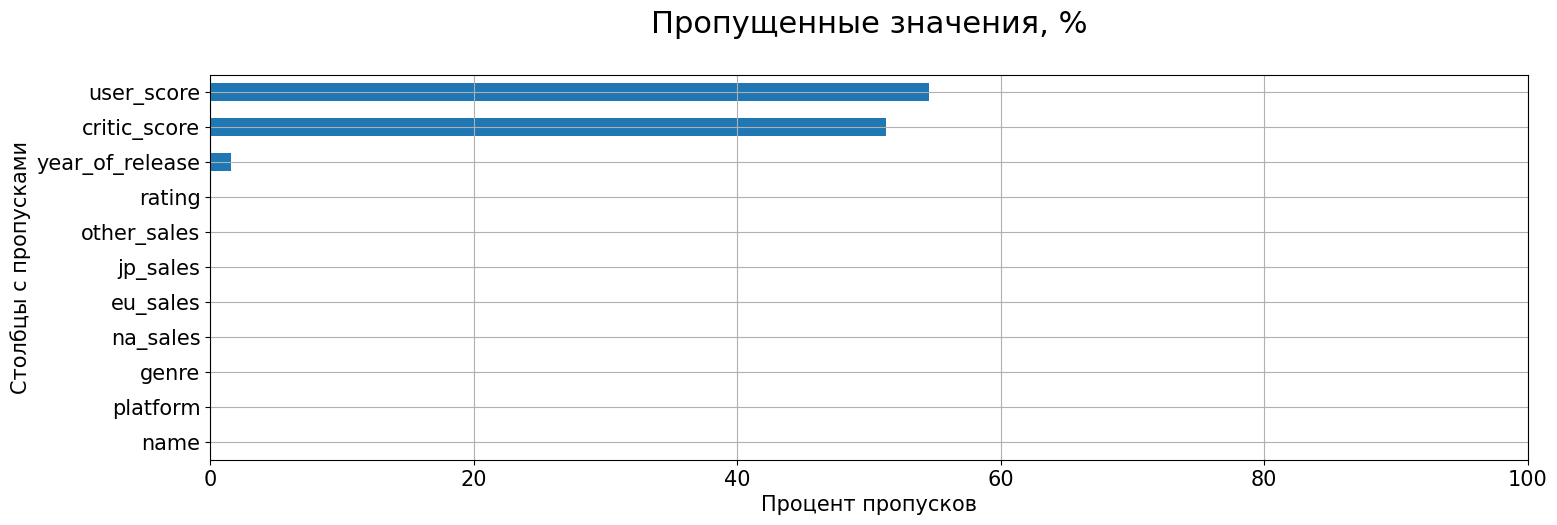

In [16]:
pass_value_barh(df)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


##### Опишите причины, которые могли привести к пропускам;

Пропуски в столбце **'year_of_release'** — "год выпуска" могли появиться по ряду причин. Во-первых, в некоторых играх в самом название указан год, это могло быть как ошибкой записи данных человеком, ошибкой в системе при записи. У некоторых игр релиз в разных странах был в разные года, это могло послужить причиной пропуска или из-за нескольких значений система не записала значения.   

Пропуски в столбце **'rating'** — "рейтинг", можно предположить, что пропуски в данном столбце появились из-за отсутствия данного рейтинга для игр, это может быть связано как с тем, что они проходили возрастной рейтинг в других компаниях или вовсе обошли его.

##### Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;

Такой оценки нет. Возможные расшифровки в первых ссылках Google, говориться о переводе "Будет определено" или "Будет удалено" первый вариант мало возможен из-за старых игр которые уже ни кто не собирается оценивать. А второй мало вероятен, так как зачем удалять того чего нет.

Проверим на дубликаты 

С начала проверим на  наличие явных дубликатов.

In [18]:
df.duplicated().sum()

0

Поиск не чего не дал. Теперь немного углубимся и поищем не явные дубликаты. Взглянем на названия платформ.

In [19]:
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Пока всё хорошо, все названия разные написаны в одном стиле и не повтаряются.

Продолжим искать уже в калонке *name*.

In [20]:
df['name'].duplicated().sum()

5154

Есть повторы, но это возможно одинаковые игры вышедшие на разных платформах, немного углубимся. Проверим на савподения сразу по трём столбцам, *name, platform, year_of_release*. 

In [21]:
df[df.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Нашли, всего одна игра, с тем же годом выхода, названием и платформой. Сравним чем два дубликата отличаются.

In [22]:
df.query('name == "Madden NFL 13" and platform == "PS3" ')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Нашелся один полностью совпадающей дубликат, с небольшой продажей в Европе. Удалим его добавив его значение к основному.

In [23]:
df.loc[604,'eu_sales'] = df.loc[604,'eu_sales'] + df.loc[16230,'eu_sales'] 
df.loc[604,'eu_sales']

0.23

In [24]:
df = df.drop(16230)

Проверим результат

In [25]:
df[df.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Всё хорошо, теперь обновим все индексы

In [26]:
df = df.reset_index(drop=True)

В нашем дата сете оказалось немного дубликатов, но это важная часть которая может сильно повлиять на результат.

##### Посчитайем суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [27]:
# df['total_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


#### Шаг 3. Проведем исследовательский анализ данных

##### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [28]:
df_d = df.query('year_of_release > 0')

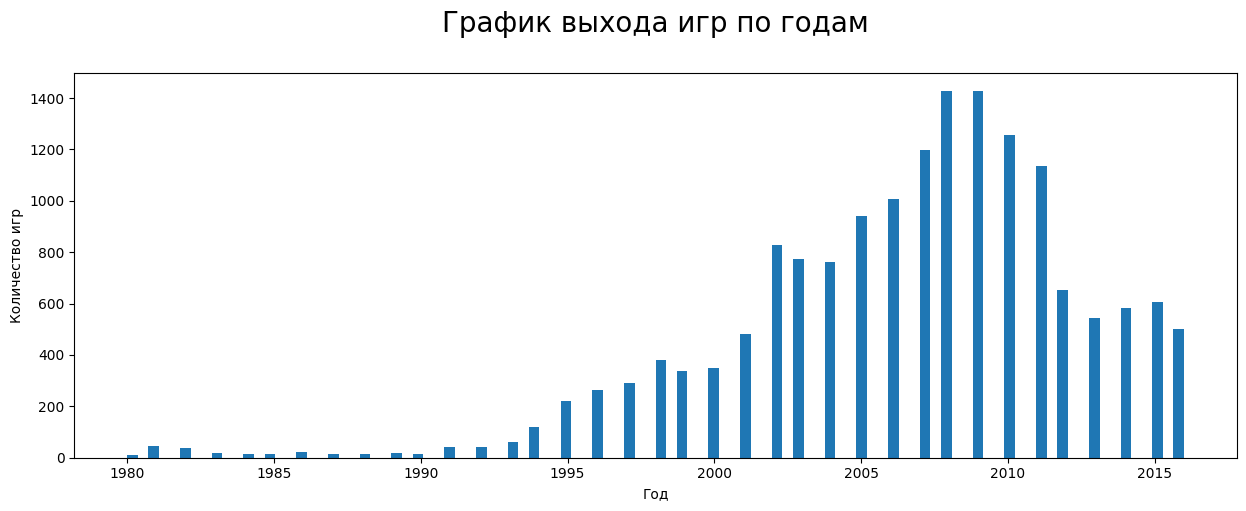

In [29]:
df_d['year_of_release'].hist(bins=100, figsize=(15,5), grid=False);
plt.title('График выхода игр по годам'+'\n', fontsize=(20));
plt.xlabel('Год');
plt.ylabel('Количество игр');

На графике видно, что пик выхода игр приходиться на 2008 - 2009 год. С 1980  по 1995 год самое маленькое количество выхода новых игр.

Посмотрим детальней на периуд с 1980 по 2000.

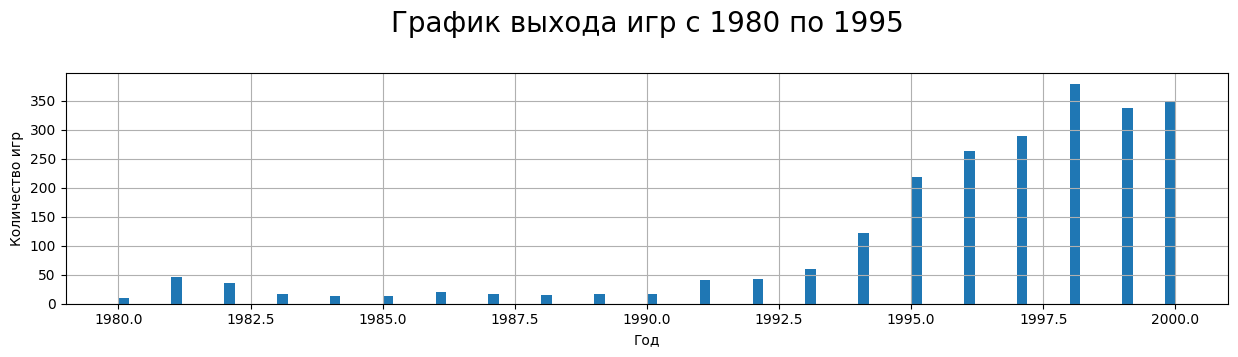

In [30]:
df_d['year_of_release'].hist(bins=100, figsize=(15,3),range=(1980,2000));
plt.title('График выхода игр c 1980 по 1995'+'\n', fontsize=(20));
plt.xlabel('Год');
plt.ylabel('Количество игр');

Считаю рациональным использовать данные с 1995 года.

##### Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам. Определим за какой характерный срок появляются новые и исчезают старые платформы.

Посчитаем сколь всего имеется компаний.

In [31]:
df_d['platform'].nunique()

31

Построим горизонтальный график с сортировкой компаний по убыванию. Сравнивать будем только компании у которых были продажи выше 100 миллионов.

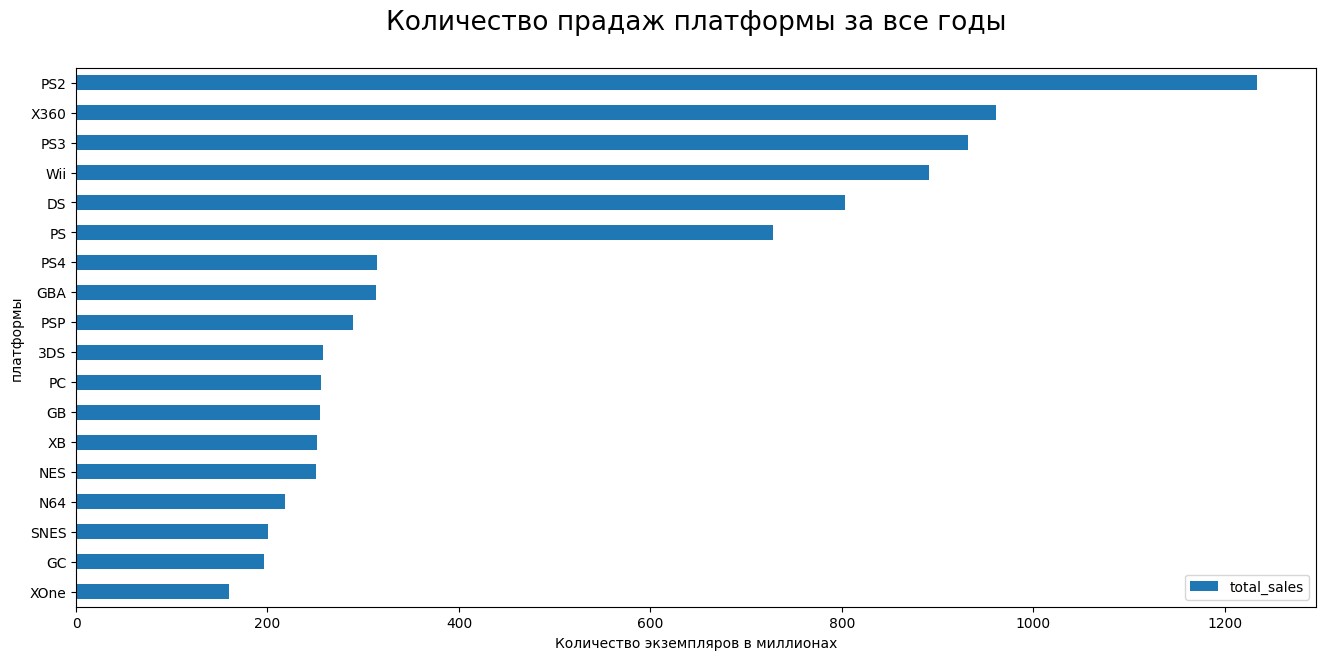

In [32]:
df_d.groupby('platform')['total_sales'].sum().sort_values().to_frame().query('total_sales > 100 ').plot.barh(figsize=(16,7));
plt.title('Количество прадаж платформы за все годы'+'\n', fontsize=(19));
plt.xlabel('Количество экземпляров в миллионах');
plt.ylabel('платформы');

Всего получилось 18 компаний с минимальным значением по продаж выше 150 миллионов.

Построим гистограмму в котором отобразим количество лет существования компании и количество проданных игр за это время.

C:\Users\1537d\AppData\Local\Temp\ipykernel_22028\1911486457.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  trup = df_d.groupby('platform').agg({'year_of_release': [min,max], 'total_sales':'sum'}).reset_index()
C:\Users\1537d\AppData\Local\Temp\ipykernel_22028\1911486457.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  trup = df_d.groupby('platform').agg({'year_of_release': [min,max], 'total_sales':'sum'}).reset_index()


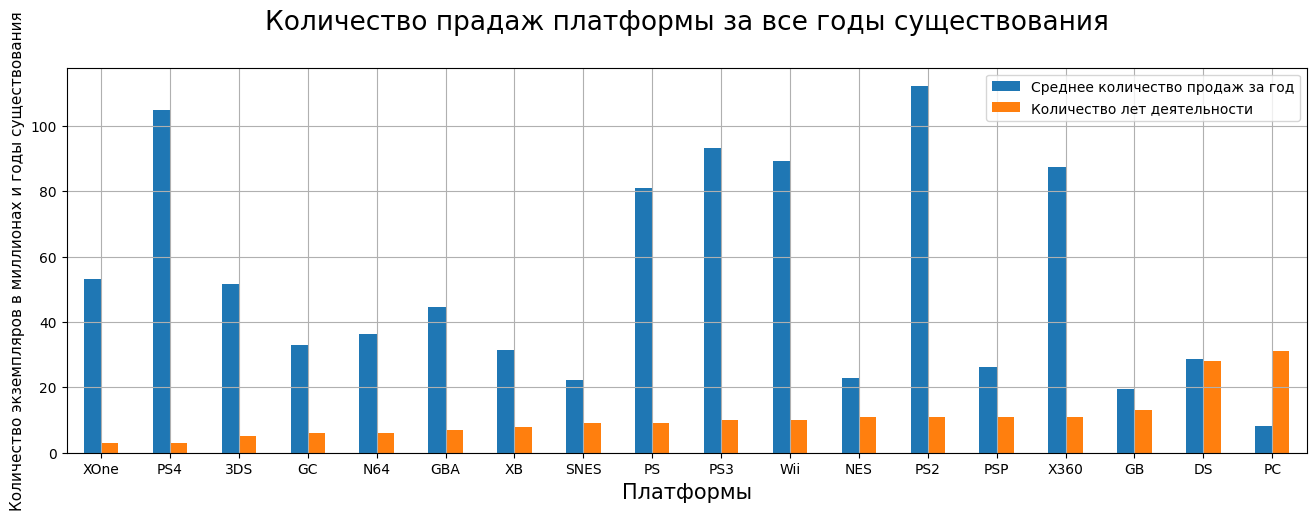

In [33]:
trup = df_d.groupby('platform').agg({'year_of_release': [min,max], 'total_sales':'sum'}).reset_index()

trup['life'] = (trup.year_of_release['max']-trup.year_of_release['min'])

trup = trup.droplevel(1, axis=1).drop('year_of_release', axis=1).query('total_sales > 100')

trup['total_sales'] = trup['total_sales']/trup['life']

(
    trup
    .rename(columns={'life':'Количество лет деятельности', 'total_sales': 'Среднее количество продаж за год'})
    .sort_values(by='Количество лет деятельности')
    .reset_index(drop=True).plot.bar(x='platform', rot = -0, figsize=(16,5), grid=True)
);


plt.title('Количество прадаж платформы за все годы существования'+'\n', fontsize=(19));
plt.xlabel('Платформы', fontsize=(15));
plt.ylabel('Количество экземпляров в миллионах и годы существования', fontsize=(11));

На графике видно, что возраст и количество продаж не имеют зависимости. 

Отсортируем общий возраст компаний по убыванию.

In [34]:
trup.sort_values(by='life', ascending=False)

,platform,total_sales,life
13,PC,8.250323,31.0
4,DS,28.670714,28.0
5,GB,19.571538,13.0
16,PS2,112.141818,11.0
28,X360,87.385455,11.0
11,NES,22.822727,11.0
19,PSP,26.320909,11.0
17,PS3,93.134000,10.0
26,Wii,89.118000,10.0
15,PS,80.842222,9.0


Мы видим двух долгожителей PC производство компьютерных игр и DS продукт Nintendo для универсальных карманных приставок.

Посчитаем средне, медиану, максимальное и минимальное значения возраста компаний.

In [35]:
 round(trup['life'].apply(['mean','median', 'min', 'max']),1)

mean      10.7
median     9.5
min        3.0
max       31.0
Name: life, dtype: float64

Средня и медиана очень близки, можно сделать предположение, что средний возраст компаний составляет 10 лет.

Построим график 6-и платформ с наибольшим количеством продаж и самую долго существующею **PC**. Уберём все продажи до 1996 года. 

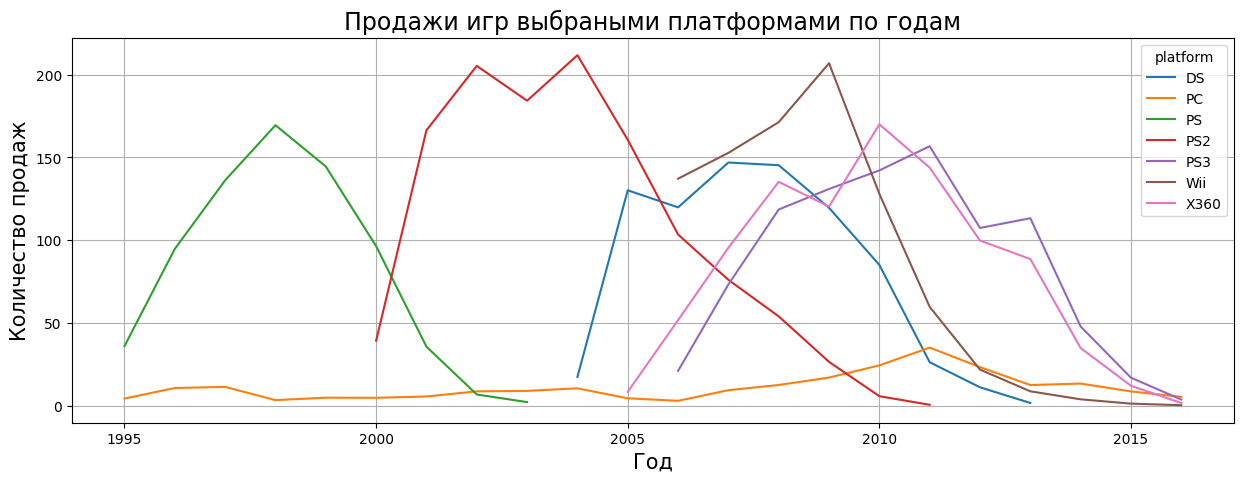

In [36]:
top_platform = df.query('platform == "X360" or platform == "PS2" or platform == "PS3" or platform == "DS" or platform == "PS" or platform == "Wii" or platform == "PC"')
top_platform = top_platform.query('year_of_release >= 1995')
(top_platform
    .pivot_table(
     index='year_of_release',
     columns='platform',
     values='total_sales',
     aggfunc={'total_sales':'sum'})
    .plot(figsize=(15,5),grid=True)
)
plt.title('Продажи игр выбраными платформами по годам', fontsize=17)
plt.ylabel('Количество продаж', fontsize=15)
plt.xlabel('Год', fontsize=15);

В среднем платформы консолей живут 7-10 лет, пик продаж для консолей приходиться со второго по пятый год выхода новой консоли(2-4 года), встречаются исключения революционных новинок к примеру Wii консоль от производителя Nintendo с интуитивно сенсорным управлением. Возможно хорошая пиар компания и новизна предложения позволила начать старт продаж с рекордных значений для любых представителей развлекательной индустрии.  

Я добавил еще одного представителя, что неустанно маячит на общем фоне. Представители игр для ПК, они не показывают рекордных продаж, но отличаются самым большим жизненным циклом и скорее всего он так и будет продолжаться. Стабильность признак мастерства.  

Хочу обратить еще внимание на период с 2007 по 2013 это время бума на консоли сразу несколько больших производителей вышли на рынок это уменьшило максимальные значения для всех, но общий объем 4-х компаний показывает огромные объёмы. На фоне массовой игровой истерии, даже продажи PC выросли, также на них влияет и обилие новых релизов на других консолях, так как их пере делывают под ПК тем самым растут продажи данного направления.

Промежуточный

In [37]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16707,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16708,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16709,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16710,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01


##### Возьмём данные за соответствующий актуальный период с 2014 по 2016.  Эти данные помогут построить прогноз на 2017 год.

Благодаря графикам выше мы увидели, что пиковые значения продаж для консолей длятся пару лет. Возьмём значения с 2014 по 2016, что бы определить какие из имеющихся сейчас компаний на иболее актуальны. 

In [38]:
df_actual = df.query('year_of_release >= 2014') #and year_of_release < 2016')
df_actual = (
    df_actual
    .pivot_table(
     index='year_of_release',
     columns='platform',
     values='total_sales',
     aggfunc={'total_sales':'sum'})
#     .reset_index(drop=True)
)
df_actual

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014.0,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015.0,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016.0,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


##### Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

В таблице за последние 2 полных года наблюдается рост у двух платформ xOne, PS4. Так же хороший результат показывает 3DS и возьмём PS3. Полное отсутствие перспективы роста, у платформ X360, Wii, PSP, PS3. А вот PC я бы оставил как надёжного и верного товарища, как стабильный пассивный доход который пока не грозит полным истощением.

##### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

Создадим сводную таблицу по 5 топовым платформам и на её основе построим графи "ящик с усами"

In [39]:
game_platform = df.query('year_of_release >= 2014 and (platform == "XOne" or platform == "PS4" or platform == "PS3" or platform == "3DS" or platform == "PC")')

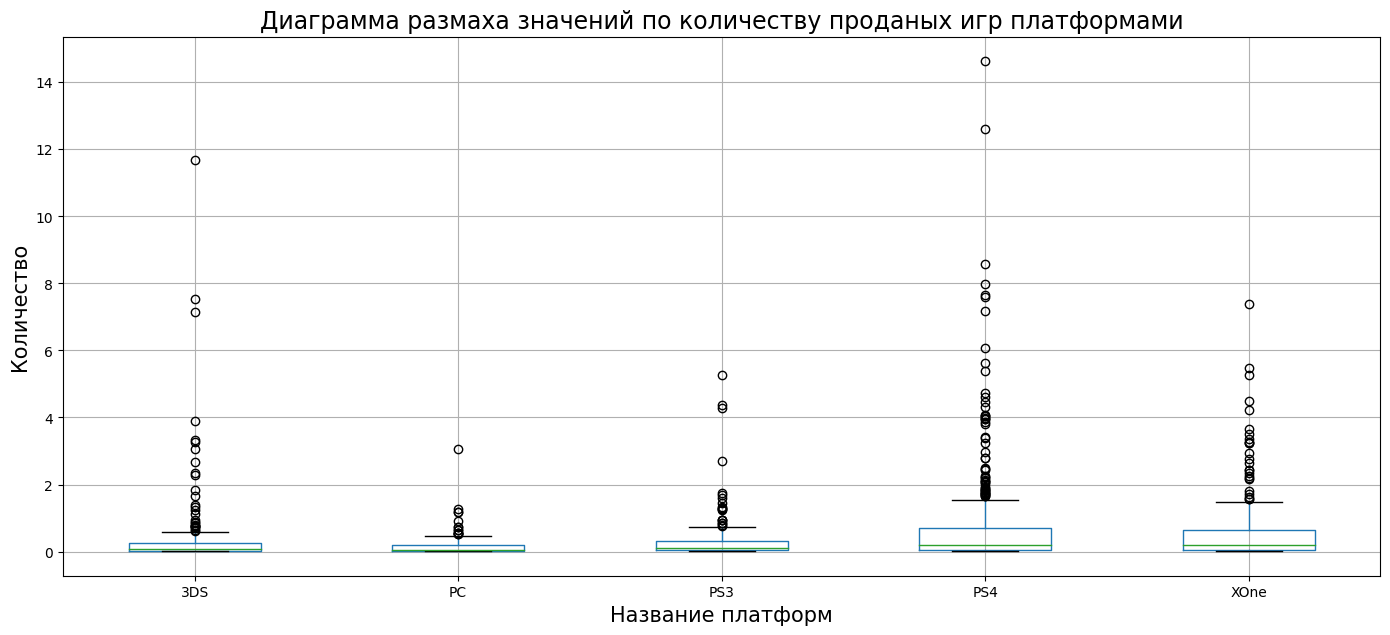

In [40]:
(
    game_platform
    .pivot_table(
     index='name',
     columns='platform',
     values='total_sales',
     aggfunc={'total_sales':'sum'})
    .boxplot(figsize=(17,7))
);
plt.title('Диаграмма размаха значений по количеству проданых игр платформами', fontsize=17)
plt.ylabel('Количество', fontsize=15);
plt.xlabel('Название платформ', fontsize=15);

Блогодаря графику можно увидеть, что у лидирующих платформ  больше размах квартилей. Значит у этих платформ выше средний показатель для всех игр, а не только некоторые релизы.

##### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.
<!-- Сформулируйте выводы. -->

Создадим переменную с играми одной из популярных платформ **PS2**. Оставив только игры, которые имеют отзывы и оценки.

In [41]:
top = df.query('platform =="PS2"')
top.shape[0]

2161

In [42]:
top = top.query('user_score >= 0 and critic_score >= 0')
top['name'].count()

1161

Получилось чуть больше 53% от общего количества всех игр этой платформы.

Теперь построим две диаграммы рассеяния для сравнения влияния оценок и рейтинга на количество продаж игр.

In [43]:
top = top[['name', 'user_score', 'critic_score', 'total_sales']]

No handles with labels found to put in legend.


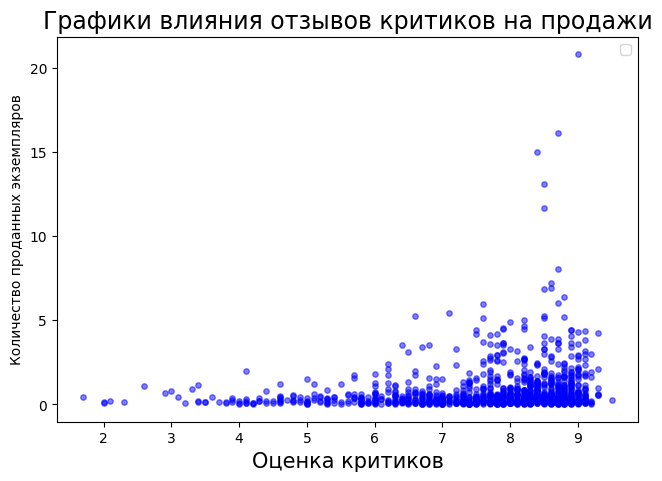

In [44]:
top.plot(kind='scatter',y='total_sales', x='user_score', alpha=0.5, subplots=True, figsize=(7.5,5), c = 'b', s = 15)
plt.title('Графики влияния отзывов критиков на продажи', fontsize=17)
plt.ylabel('Количество проданных экземпляров', fontsize=10)
plt.xlabel('Оценка критиков', fontsize=15);

No handles with labels found to put in legend.


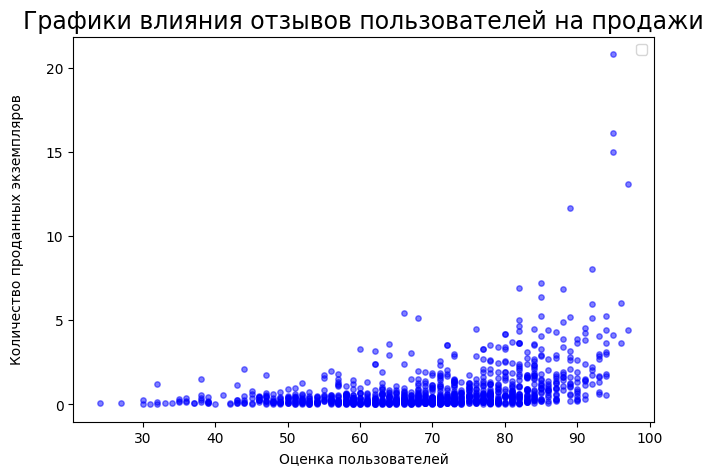

In [45]:
top.plot(kind='scatter',y='total_sales', x='critic_score', alpha=0.5,subplots=True, figsize=(7.5,5), c = 'b', s = 15)
plt.title('Графики влияния отзывов пользователей на продажи', fontsize=17)
plt.xlabel('Оценка пользователей', fontsize=10) # подпись оси х
plt.ylabel('Количество проданных экземпляров'+ '\n', fontsize=10); # подпись оси у

Наблюдается не большая зависимость от оценок критиков и минимальная от пользователей.

##### Соотнесите выводы с продажами игр на других платформах.

Построим диаграмму для всех игр на всех платформах с оценкой критиков и количество продаж. Также для более наглядного примера уберем все нулевые значения.

No handles with labels found to put in legend.


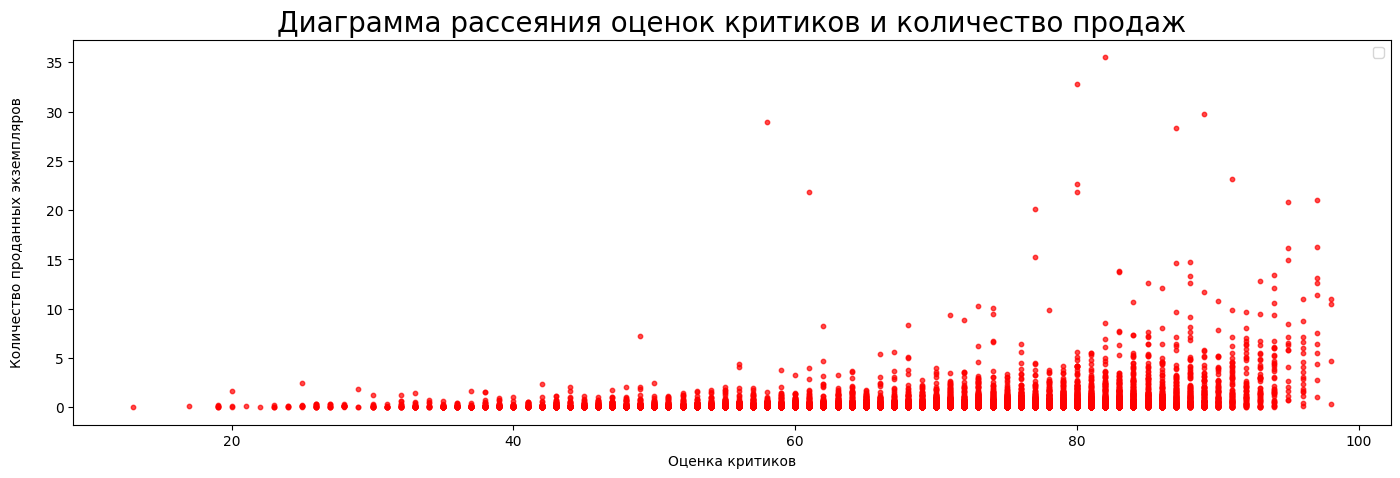

In [46]:
# df[['name', 'user_score', 'critic_score', 'total_sales']]
(
df[['name', 'user_score', 'critic_score', 'total_sales']].query('critic_score > 0 and total_sales < 60') # также уберем одну игру со сверх продажами с выше 60 миллионов.
    .plot(kind='scatter',
    y='total_sales', 
    x='critic_score', 
    alpha=0.7, 
    subplots=True, 
    figsize=(17,5), 
    c = 'r', 
    s = 10)
)
    
plt.title('Диаграмма рассеяния оценок критиков и количество продаж', fontsize=20);
plt.xlabel('Оценка критиков', fontsize=10) # подпись оси х
plt.ylabel('Количество проданных экземпляров'+ '\n', fontsize=10);

Несмотря на общую тенденцию, есть много игр выбивающихся из соотношения, чем лучше оценка тем больше продаж.

Построим вторую диаграмму для оценок пользователей.

No handles with labels found to put in legend.


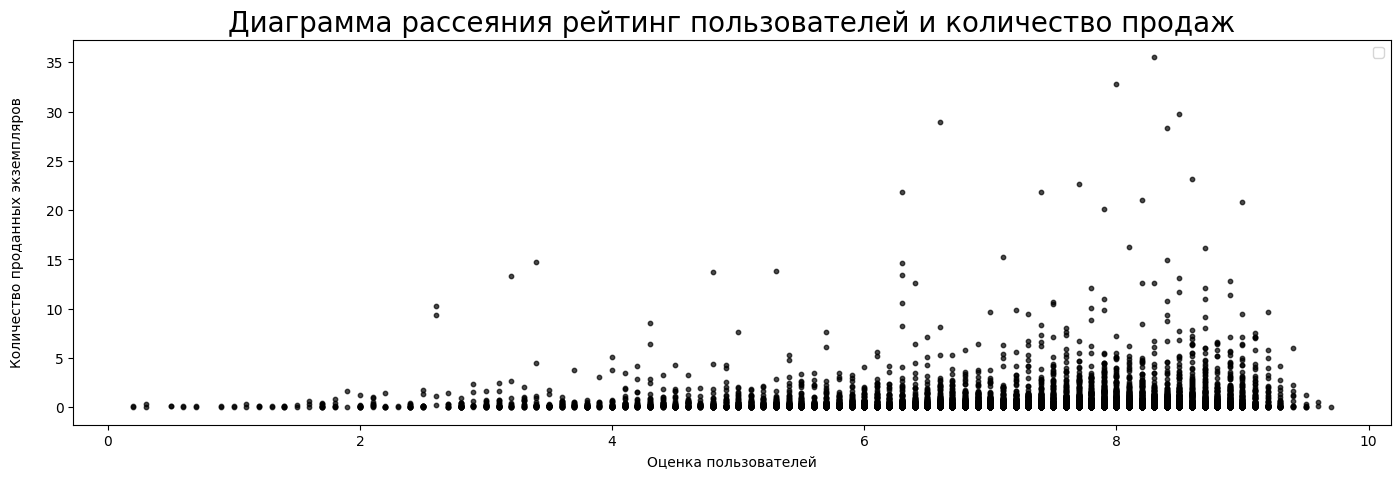

In [47]:
(
df[['name', 'user_score', 'critic_score', 'total_sales']].query('user_score > 0 and total_sales < 60')
    .plot(kind='scatter',
        y='total_sales',
        x='user_score',
        alpha=0.7,
        subplots=True,
        figsize=(17,5),
        c = 'black',
        s = 10)
)
plt.title('Диаграмма рассеяния рейтинг пользователей и количество продаж', fontsize=20);
plt.xlabel('Оценка пользователей', fontsize=10) # подпись оси х
plt.ylabel('Количество проданных экземпляров'+ '\n', fontsize=10);

Если смотреть на всю картину из имеющихся у нас данных, мы видим очень сильную зависимость продаж от оценок пользователей и не большую зависимость от оценок критиков. В пункте 3.6 данные были обратными, возможно это связано с высоким авторитетом критиков по данной платформе или хорошей работой отдела маркетинга  или очень плохим сервисом для оценки от пользователей. Но одно стало явно, что оценка игры пользователями очень важна для объёмов продаж игры.

##### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Создадим новую переменную в которой объединим все игры по жанрам.

In [48]:
df_genre =( 
            df
            .pivot_table(
                index='genre',
                values='total_sales',
                aggfunc=sum)
            .sort_values(
                by='total_sales',
                ascending=False)# группируем и считаем сумму
)

C:\Users\1537d\AppData\Local\Temp\ipykernel_22028\3509974783.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df


 Построим график жанров с сортировкой от большего к меньшему в процентах от общего количества продаж.

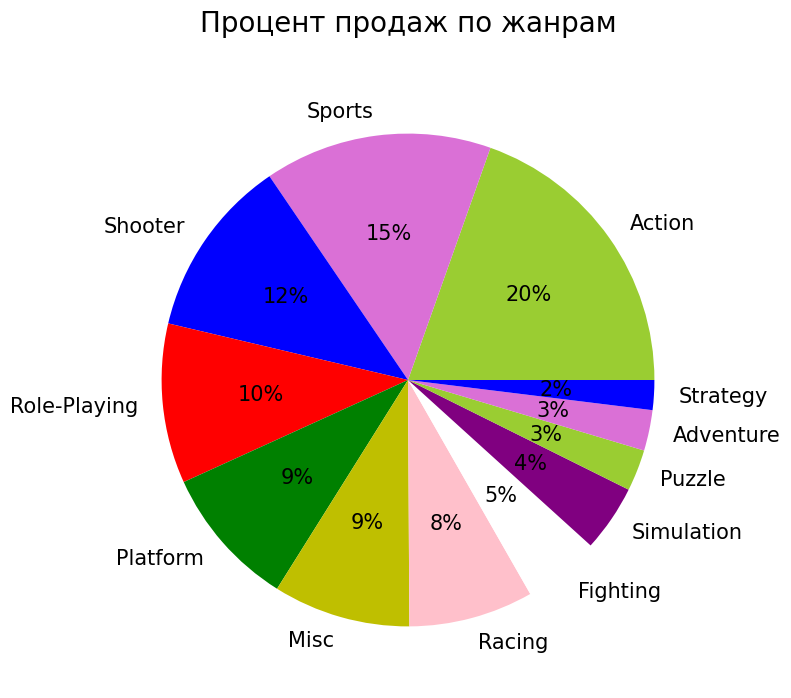

In [49]:
(df_genre
    .plot(                          # запускаем функцию графиков 
        y='total_sales',                
        kind='pie',                 # выбираем модель графика пирог
        autopct='%1.0f%%',          # отображение процентов на графике
        figsize=(17,8),             # размер графика
        fontsize=15,                # размер шрифта
        colors = ['yellowgreen', 'orchid','b','r','g','y','pink', 'w','Purple'], legend=None)  # цветовые предпочтения(у меня с этим плохо:))
);

plt.title('Процент продаж по жанрам' + '\n', fontsize=20) # подпись графика
plt.ylabel(''); # уберём подпись оси y 

Самые продоваемые жанры **Action** (англ. «действие», экшен-игры) и **Sports** (англ. «спортивные соревнования»). Эти жанры занимают 35% процентов от общего рынка. А вот **Strategy, Adventure, Puzzle, Simulation** имеют всего 12%.

Теперь посчитаем среднее соотношение выпущенных и проданных игр каждого жанра

In [50]:
mean_price_genre = df.groupby('genre')['total_sales'].sum()/df.groupby('genre')['name'].count()

Соберём всё в одну таблицу. И переведём наши значения в тысячи

In [51]:
df_genre['mean_sales'] = mean_price_genre*1000

Построим таблицу, что бы наглядно оценить соотношение выпущенных игр и количество проданных экземпляров

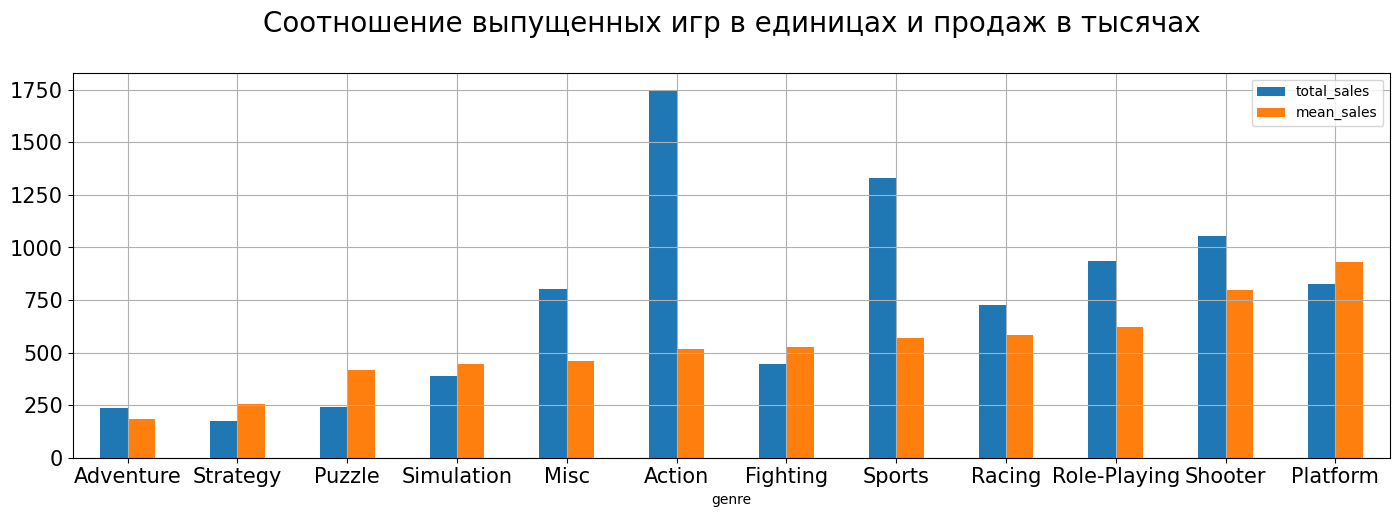

In [52]:
mean_price_genre = df.groupby('genre')['total_sales'].sum()/df.groupby('genre')['name'].count()
df_genre['mean_sales'] = mean_price_genre*1000
df_genre.sort_values(by='mean_sales', ascending=True).plot.bar(rot=0,figsize=(17,5), fontsize=15, grid=True);
plt.title('Соотношение выпущенных игр в единицах и продаж в тысячах' + '\n', fontsize=20);

На таблице видно, что самый продаваемый жанр **Platform** так же можно сказать, что **Ation и Sports**  занимают большой кусок рынка благодаря объёму предложений, а не качественным продажам. Ещё стоит обратить внимание на **Puzzle, Strategy, Simulation и Fighting** в этих жанрах на одну игру приходиться болше 1000 продаж.

#### Шаг 4. Составьте портрет пользователя каждого региона
##### Определите для пользователя каждого региона (NA, EU, JP):

###### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

Взглянем на общие продажи по всем платформам в Северной Америке

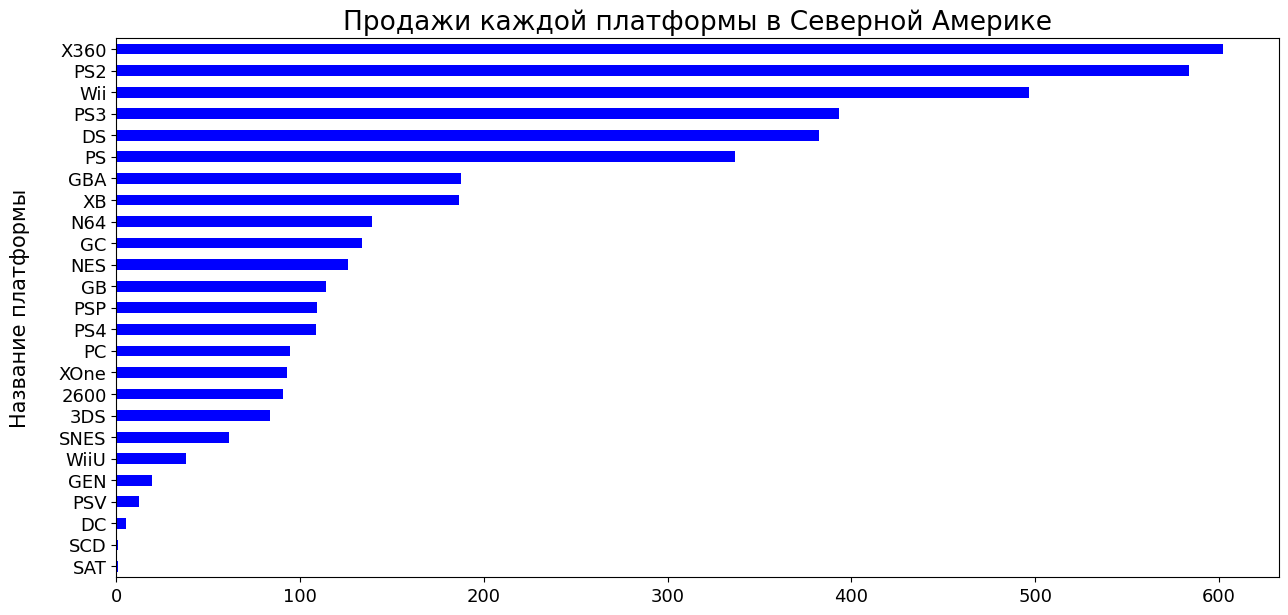

In [53]:
(df
    .query('na_sales > 0')
    .groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=True)
    .plot(kind='barh',
         rot=0,
         figsize=(15,7),
         fontsize=13,
         color='blue')
);
plt.title('Продажи каждой платформы в Северной Америке', fontsize=19);
plt.ylabel('Название платформы'+'\n', fontsize=15);

Теперь посмотрим как разделены доли продаж между (топ-5)

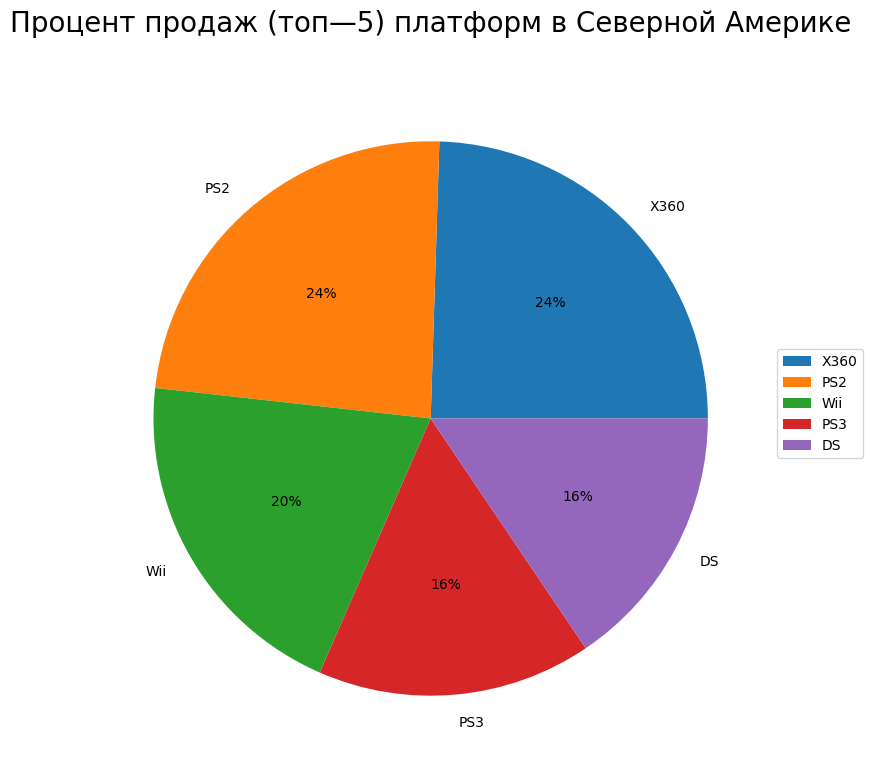

In [54]:
(df
    .query('na_sales > 0')
    .groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(                          # запускаем функцию графиков 
        kind='pie',                 # выбираем модель графика пирог
        y='total_sales',                
        autopct='%1.0f%%',          # отображение процентов на графике
        figsize=(17,9),             # размер графика
        fontsize=10)                # размер шрифта
);
plt.legend(bbox_to_anchor=( 1 , 0.6 ), loc='upper left', borderaxespad= 0 )
plt.title('Процент продаж (топ—5) платформ в Северной Америке' + '\n', fontsize=20) # подпись графика
plt.ylabel(''); # уберём подпись оси y 

PS2 и X360 занимают практически половину, Wii получает 1/5, PS3 и DS делят пополам 1/3

Первые 5 платформ **X360, PS2, Wii, PS3, DS** занимают 14/25 от всего рынка Северной Америки или 56%, то есть больше одной второй.

Взглянем на общие продажи по всем платформам в Европе

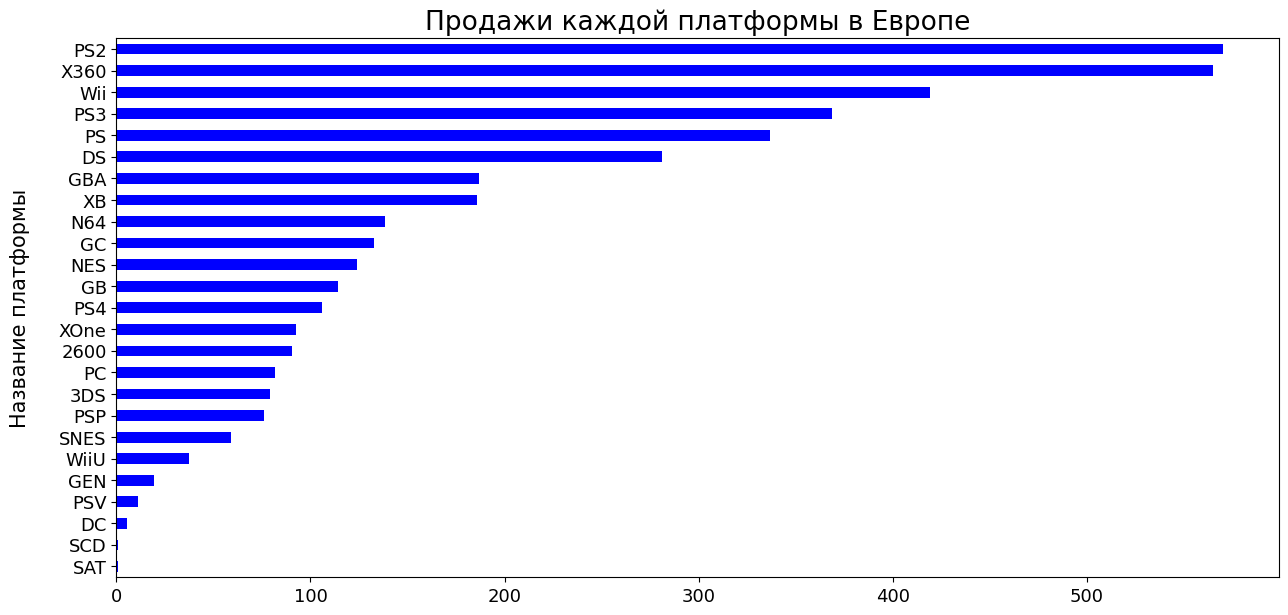

In [55]:
(df
    .query('eu_sales > 0')
    .groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=True)
    .plot(kind='barh',
         rot=0,
         figsize=(15,7),
         fontsize=13,
         color='blue')
);
plt.title('Продажи каждой платформы в Европе', fontsize=19);
plt.ylabel('Название платформы'+'\n', fontsize=15);

Теперь посмотрим как разделены доли продаж между (топ-5)

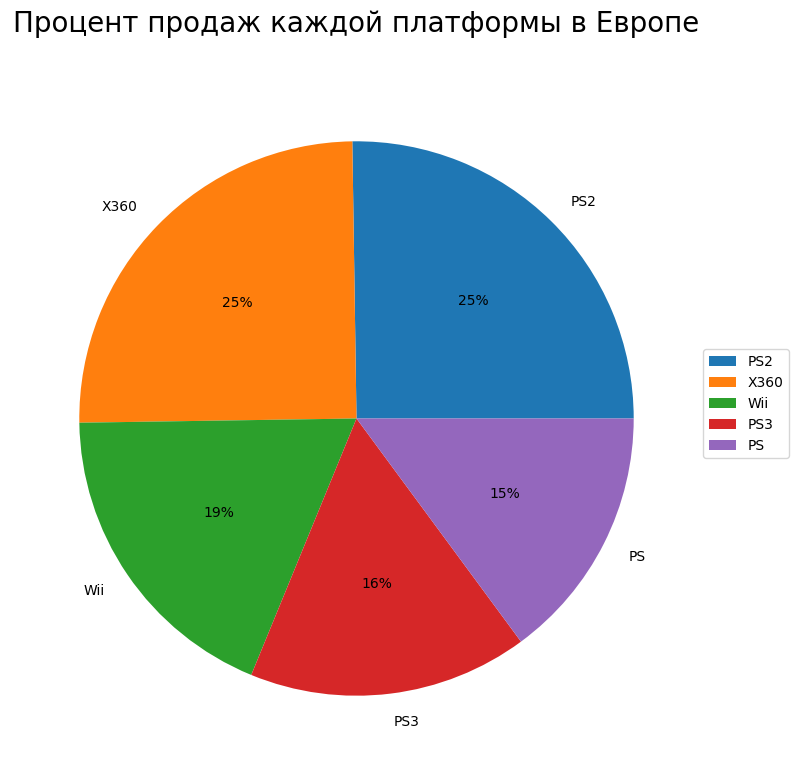

In [56]:
(df
    .query('eu_sales > 0')
    .groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(                          # запускаем функцию графиков 
        y='total_sales',                
        kind='pie',                 # выбираем модель графика пирог
        autopct='%1.0f%%',          # отображение процентов на графике
        figsize=(17,9),             # размер графика
        fontsize=10)                # размер шрифта
);

plt.legend(bbox_to_anchor=( 1 , 0.6 ), loc='upper left', borderaxespad= 0 )
plt.title('Процент продаж каждой платформы в Европе' + '\n', fontsize=20) # подпись графика
plt.ylabel(''); # уберём подпись оси y 

Ситуация очень похожа на Северную америку с небольшими отклонениями в 1%

В Европе люди разделились практически поровну между двумя лидерами **PS2 и X360**. **Wii и PS3** сохраняет позиции 3 и 4 место, а вот на пятое место выходит компания **PS**. В Европе 5 лидеров занимает 11/20 или 55%, но все также это больше одной второй общего рынка.

Взглянем на общие продажи по всем платформам в Япони

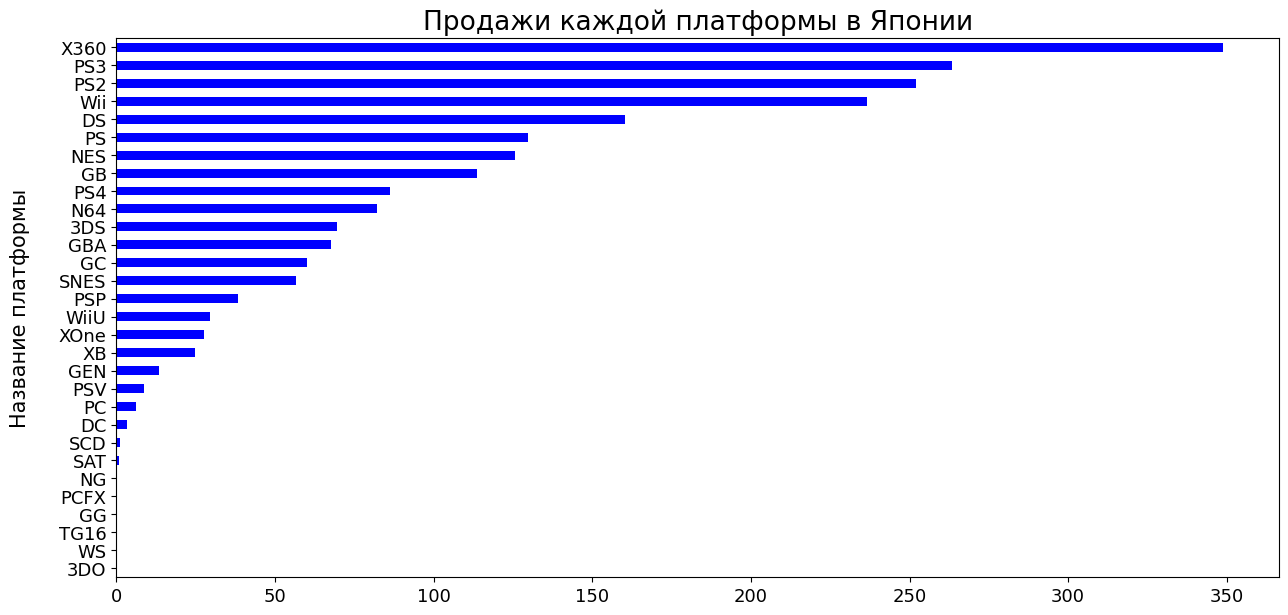

In [57]:
(df
    .query('jp_sales > 0')
    .groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=True)
    .plot(kind='barh',
         rot=0,
         figsize=(15,7),
         fontsize=13,
         color='blue')
);
plt.title('Продажи каждой платформы в Японии', fontsize=19);
plt.ylabel('Название платформы'+'\n', fontsize=15);

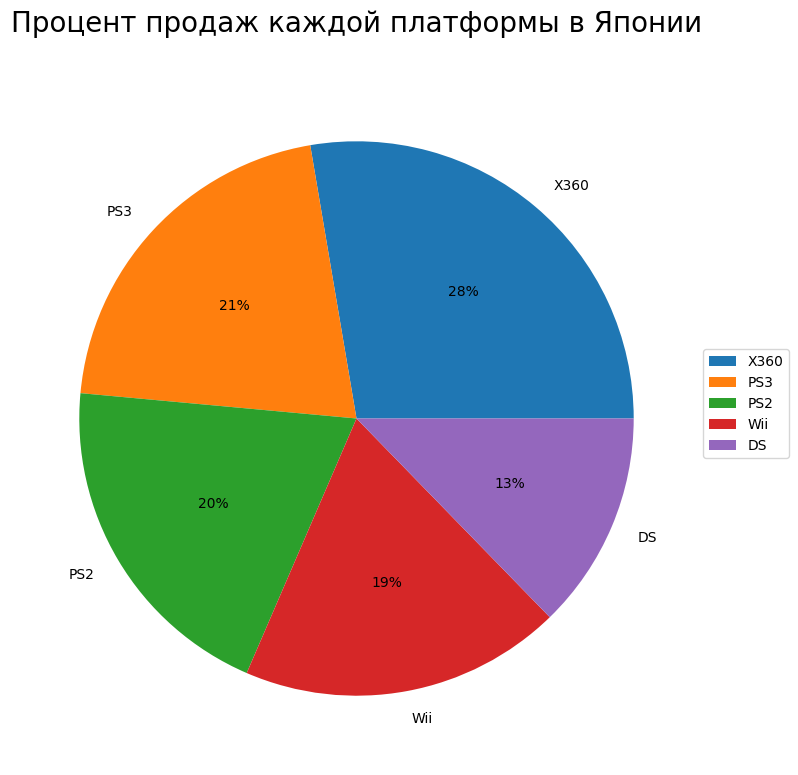

In [58]:
(df
    .query('jp_sales > 0')
    .groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(                          # запускаем функцию графиков 
        y='total_sales',                
        kind='pie',                 # выбираем модель графика пирог
        autopct='%1.0f%%',          # отображение процентов на графике
        figsize=(17,9),             # размер графика
        fontsize=10)                # размер шрифта
);
plt.legend(bbox_to_anchor=( 1 , 0.6 ), loc='upper left', borderaxespad= 0 )
plt.title('Процент продаж каждой платформы в Японии' + '\n', fontsize=20) # подпись графика
plt.ylabel(''); # уберём подпись оси y 

Здесь расстановка сил отличается X360 занимает почти 1/3, а PS2, PS3 и Wii в среднем получили по 1/5 и замыкает 5-ку лидеров DS которой досталась чуть больше 1/10.

Япония отдаёт уверенное предпочтение **X360. PS3** смещает **PS2 и Wii** и замыкает топ **DS**. Топ 5 компаний занимают 57/100 или 57% рынка игр. 

###### Самые популярные жанры (топ-5). Поясните разницу.

Сгруппируем все продажи в требуемой нам стране по жанрам и построим график.

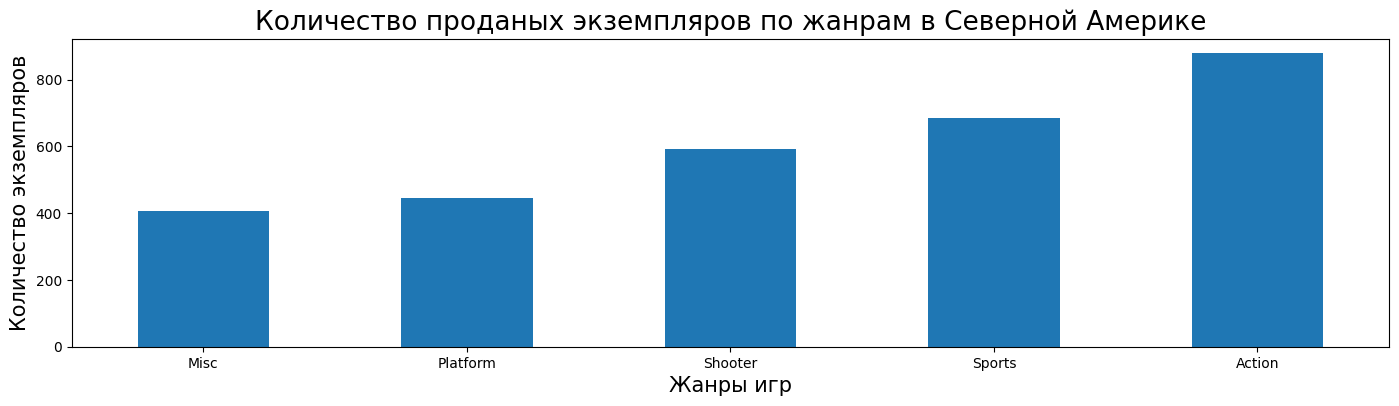

In [59]:
df.groupby('genre')['na_sales'].sum().sort_values().tail().plot.bar(rot=0,figsize=(17,4));
plt.title('Количество проданых экземпляров по жанрам в Северной Америке', fontsize=19)
plt.ylabel('Количество экземпляров', fontsize=15)
plt.xlabel('Жанры игр', fontsize=15);


В Северной Амереки в топ 5 входят Action, Sports, Shooter, Platform, Misc.

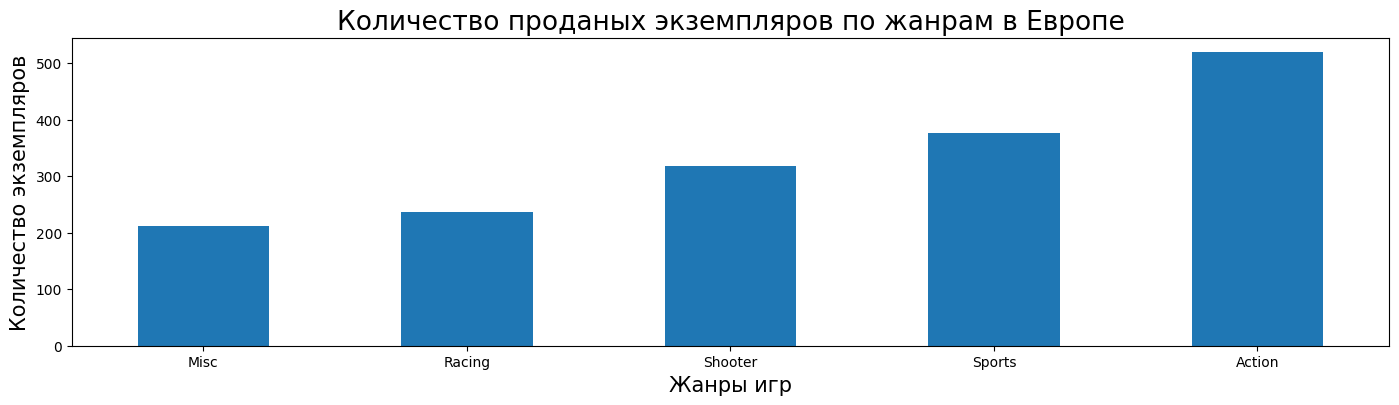

In [60]:
df.groupby('genre')['eu_sales'].sum().sort_values().tail().plot.bar( rot=0,figsize=(17,4));
plt.title('Количество проданых экземпляров по жанрам в Европе', fontsize=19)
plt.ylabel('Количество экземпляров', fontsize=15)
plt.xlabel('Жанры игр', fontsize=15);

В Европе схожие топ 5 Action, Sports, Shooter, Racing, Misc. Игроки предпочитаю Racing в место Platform

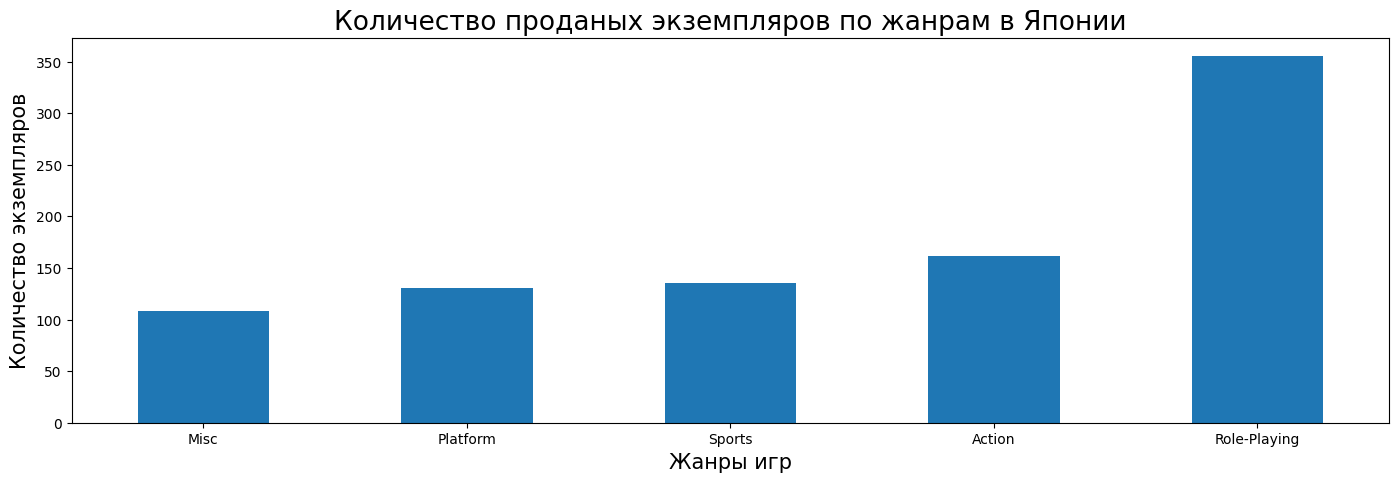

In [61]:
df.groupby('genre')['jp_sales'].sum().sort_values().tail().plot.bar( rot=0,figsize=(17,5));
plt.title('Количество проданых экземпляров по жанрам в Японии', fontsize=19)
plt.ylabel('Количество экземпляров', fontsize=15)
plt.xlabel('Жанры игр', fontsize=15);

В Японии на первом месте лидирует жанр Role-Playing практически в два раза превосходя остальные жанры. Дальше распределение жанров очень схожи с Северной Америкой Action, Sports, Platform, Misc. Здесь Shooter пропал из лидеров.

###### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

  **«EC»** («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет  
  **«E»** («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов (ранее с 6 лет).Первоначально **"K-A"** ("Kids to Adults"):  
  **«E10+»** («Everyone 10 and older») — «Для всех от 10 лет и старше»:Рейтинг был принят ESRB 2 марта 2005 года.  
  **«T»** («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.  
  **«M»** («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.  
  **«AO»** («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.  
  **«RP»** («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.
  **«RP 17+»** («Rating Pending») — «Рейтинг ожидается - примерно 17+»: Продукт отправлен ESRB на оценку, но примерное содержание близко к рейтингу «M». Данная маркировка была введена с 2021 г. и распространяется на демо или презентационный вариант

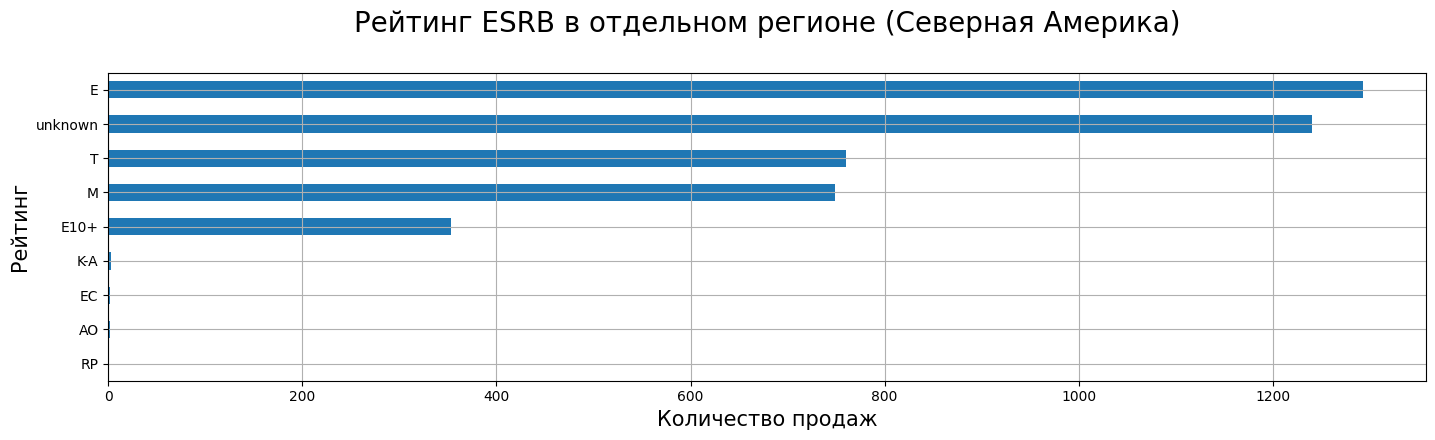

In [62]:
df.groupby('rating')['na_sales'].sum().sort_values().plot.barh(rot=0, figsize=(17,4), grid=True)
plt.title('Рейтинг ESRB в отдельном регионе (Северная Америка)' + '\n', fontsize=20)
plt.ylabel('Рейтинг', fontsize=15)
plt.xlabel('Количество продаж', fontsize=15);

 В Северной Америки больше всего выбирают игры подходящие для всех или вовсе не имеющие оценку, золотая середина достаётся категории подростков и взрослым. Реже всего встречаеться рейтинг Е10+, это может быть связано с тем, что его начали использовать только с 2005 года.

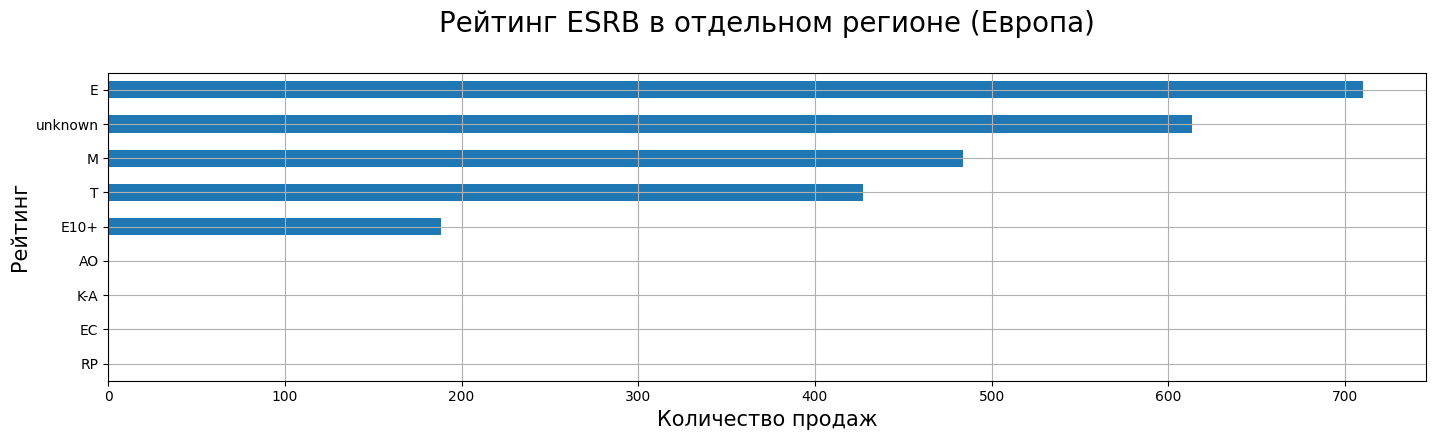

In [63]:
df.groupby('rating')['eu_sales'].sum().sort_values().plot.barh(rot=0, figsize=(17,4), grid=True)
plt.title('Рейтинг ESRB в отдельном регионе (Европа)' + '\n', fontsize=20)
plt.ylabel('Рейтинг', fontsize=15)
plt.xlabel('Количество продаж', fontsize=15);

В Европе схлжая сситуация с более плавными переходами.

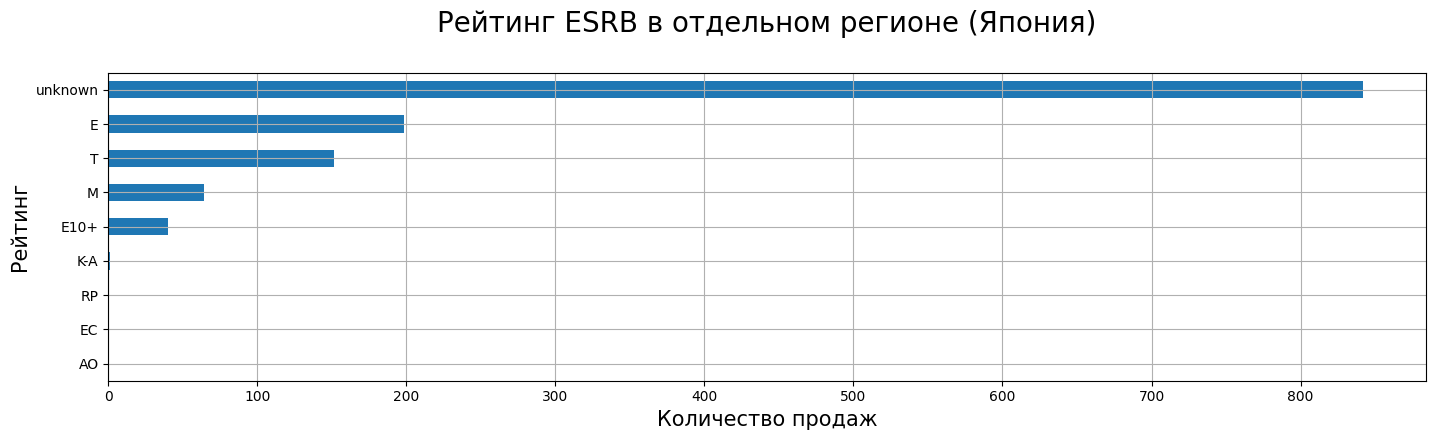

In [64]:
df.groupby('rating')['jp_sales'].sum().sort_values().plot.barh(rot=0, figsize=(17,4), grid=True)
plt.title('Рейтинг ESRB в отдельном регионе (Япония)' + '\n', fontsize=20)
plt.ylabel('Рейтинг', fontsize=15)
plt.xlabel('Количество продаж', fontsize=15);

А вот в Японии рейтинг допустимого возраста очень значим для игроков. Большинство выбирает игры, которые не имеют оценки. Также возможно, что многие игры продаваемые в Японии просто не проходят оценку данного рейтинга. При этом общая тенденция сохраняеться и сдесь. 

#### Шаг 5. Проверьте гипотезы

###### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Создадим новую переменную в которую запишем только информацию о Xbox One c оценками пользователями и посчитаем количество значений в нашей выборке.

In [65]:
rating_xbox = df.query('platform == "XOne" and user_score > 0') 
rating_xbox.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
165,Grand Theft Auto V,XOne,2014.0,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014.0,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26
242,Halo 5: Guardians,XOne,2015.0,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49


In [66]:
rating_xbox.shape[0]

182

Всего получилось 182 оценки.

Соберем такиеже данные о PC.

In [67]:
rating_pc = df.query('platform == "PC" and user_score > 0') 
rating_pc.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
85,The Sims 3,PC,2009.0,Simulation,0.99,6.42,0.0,0.60,86.0,7.6,T,8.01
138,World of Warcraft,PC,2004.0,Role-Playing,0.08,6.21,0.0,0.00,93.0,7.3,T,6.29
192,Diablo III,PC,2012.0,Role-Playing,2.44,2.16,0.0,0.54,88.0,4.0,M,5.14


In [68]:
rating_pc.shape[0]

770

Получилось 770 строк в 4 раза больше чем для Xbox one

Выдвинем нулевую гипотезу, что средне значение рейтинга пользователей платформ **Xbox One** и **PC** равны. Альтернативной гипотезой будет, что средние отличаются.

In [69]:
alpha = 0.05  # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(rating_xbox['user_score'], rating_pc['user_score'], equal_var=False) # проводим ttest

print('p-значение', results.pvalue)

if results.pvalue < alpha:            # проверяем p-value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение 4.935072360183565e-06
Отвергаем нулевую гипотезу


Значение P далеко от нашей альфы, а значит средня оценка для двух платформ отличается

###### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Создадим две новы переменные для жанров с оценками пользователей и посчтиаем их.

In [70]:
action_rating = df.query('genre == "Action" and user_score > 0')
action_rating.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
17,Grand Theft Auto: San Andreas,PS2,2004.0,Action,9.43,0.40,0.41,10.57,95.0,9.0,M,20.81
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27


In [71]:
action_rating.shape[0]

1830

Мы вывели в отдельную переменную все необходимые строки с требуемым нам жанром и у которых есть оценка. И подсчитали их все.

Повторим то же самое для второго жанра.

In [72]:
sports_rating = df.query('genre == "Sports" and user_score > 0')
sports_rating.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
13,Wii Fit,Wii,2007.0,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E,22.70


In [73]:
sports_rating.shape[0]

1102

Теперь мы собрали все данные, что бы мы могли приступить к построению и проверки нашей гипотезы.

Возьмём за нулевую гипотезу утверждение, что средний пользовательский рейтинг жанров не разный.
А за альтернативную гипотезу, что они разные.

In [74]:
alpha = 0.05  # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sports_rating['user_score'], action_rating['user_score'], equal_var=False)

print('p-значение', results.pvalue)       # проводим ttest

if results.pvalue < alpha:               # проверяем p-value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение 0.12024530426190538
Не получилось отвергнуть нулевую гипотезу


Гипотеза не получилось опровергнуть, значит, средняя оценка двух жанров не разные. И в изучаемых данных нельзя сказать, что два жанра отличаются по оценкам пользователей.

##### Пояснение:

###### Как вы сформулировали нулевую и альтернативную гипотезы;

Я сформировал гипотезу в пункте 5.0.1 исходя из вопроса. Если они равны, то значения пивелью было бы больше альфы. Но в ходе проверки нулевая гипотеза была отвергнута. Альтернативная гипотеза была сформулирована, на основание, что если нулевая гипотеза не верна, значит исследуемые значения разные.

В пункте 5.0.2 я сформировал нулевую гипотезу от обратного. Если наши значения не разные, то они разные. Альтернативной гипотезой стал вопрос в данном пункте, что значения разные.

###### Какой критерий применили для проверки гипотез и почему.

В Python есть специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind(array1, array2, equal_var, alternative). Также мы при тестировании мы использовали *equal_var*  — необязательный параметр. Он управляет тем, будет ли метод считать равными дисперсии выборок. Передаётся как equal_var=True или equal_var=False (True — считать, False — не считать). По умолчанию — True. Использовали его так как наши выборки отличаются по количеству значений.


#### Общий вывод

В ходе анализа данных мы выяснили, что наиболее перспективны платформы со средним возрастом 2-3 года, так ка в этот период они представляют пик своей активности. Также мы узнали, что средня продолжительность существования платформы 7-10 лет, по этому не стоит выбирать игры платформ чей возраст подошел к критической отметке. Есть исключение из правил **PC** производитель игр для компьютеров. Несмотря на незначительны показатели продаж эта платформа отличается стабильностью в своём сегменте, она стабильно приносит 2% от Европейского Северо Американского и Японского рынка. Не все молодые платформы удерживаются на плову и могут сгореть в первые 3 года. Как правило, у таких платформ продажи с самого начала не выгляди утешающими. Сейчас наиболее успешными кажутся xOne и PS4. А вот у платформ X360, Wii, PSP, PS3 нет будущего рекомендовал бы отказаться, от приобретения продукции этих производителей. Также для увелечения предложений возможно рассмотреть предложения платформ 3DS и PS3, но только в краткосрочный период так как жизнь этих платформ перешла за золотую середину и начинает клониться к закату.

Считаю важным следить за рейтингами игр, а также трендами, так как есть исключительные игры которые вносят очень большой вклад в общее количество продаж платформы.

Также стоит обращать внимание на жанр игр, популярные во всем мире Action, Sports, Shooter, Platform, Misc, Racing и Role-Playing эти 7 жанров занимают 83% от общего рынка. Хочу обратить внимание, что Role-Playing Самый популярный жанр в Японии и его высокий показатели продаж связаны именно с этой страной. 

Так же в данной работе нам стало видно, что количество продаж игры достаточно сильно зависит, от оценок игроков, немало важным фактором является и оценка критиков. 

Жанр **Platform** имеет самые высокие показатели как по полярности так и по количеству средних продаж на 1 игру, а вот **Ation и Sports**  занимают лидирующие позиции по количеству продаж только из-за большого количества разнообразия игр, что может сильно раздуть наш ассортимент без положительных результатов для выручки, при выборе игр данного жанра стоит быть особенно осторожным, опираться на тренды и оценки пользователей и критиков. Жанры **Puzzle, Strategy, Simulation и Fighting** отлично подойду для разнообразия ассортимента и поднятию продаж, несмотря на небольшой выбор игр каждый жанр в среднем продает больше 1000 экземпляров для одной игры.

При выборе игр для продажи в нашем сервисе стоит обращать внимание на рейтинг возраста игры. На графиках в пункте 4.1.3 видно, что больше всего продано игр без ограничения возраста или не прошедших оценку данного рейтинга. Для некоторых регионов отсутствие рейтинга положительно сказывается на продажах особенно явно это видно на примере Японии.

Ещё мы проверили пару гипотез из которых можно сделать, предположение, что пользователи разных платформ по-разному оценивают игры, а вот жанры игры не влияет на взгляд игрока.

